In [1]:
%load_ext autoreload
%autoreload 2

import utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from catboost import CatBoostClassifier

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, \
        PrecisionRecallDisplay, average_precision_score

In [3]:
%%time
df = utils.get_wide_df()
df.head(2)

CPU times: user 2min 8s, sys: 1.66 s, total: 2min 10s
Wall time: 2min 10s


,Unnamed: 0.1,Unnamed: 0,assignment_level,attempts_date_created,cl_date_assignment,cl_id,cls_date_created,cls_student_id,course_id,is_solved,problem_id,subject_slug,team_id,team_level,tp_teacher_id
0,0,0,3,2022-03-08 11:02:37+03:00,2022-03-05 13:00:00+03:00,71374307,2022-03-08 10:52:43+03:00,1650006,5096626,1,97304,mathematics,82516,4,520541
1,1,1,3,2022-03-08 11:02:49+03:00,2021-09-02 14:23:50+03:00,70879797,2022-03-08 11:02:08+03:00,1494142,5099807,1,227546,mathematics,69290,4,615530


Добавить среднее время выполнения задачи для каждого (посмотреть медиану) (в разбивке по типам задач)
Добавить difficulty из ctt_simple
Выделить важные узлы и посмотреть сколько в каждом из узлов решил задач
Тип задачи выставить (из графа)
Выделить из графа наиболее важные узлы (центральность)

Добавить класс студента
И сколько процентов графа он освоил

Сделать для русского языка

Добавить инфу про Limits (математики)
Можно добавить инфу про stack ()

В итоговом отчёте хочется увидеть самые сильные и самые слабые фичи (про графф вставить на сколько пререки важны)

Хочется что-то наглядное (пример скрипт, который покажет какие задачи студент может решить из тех, что не решал ранее и которые выше в графе)
(вывести по 8 задач)

In [4]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
df.head(2)

,assignment_level,attempts_date_created,cl_date_assignment,cl_id,cls_date_created,cls_student_id,course_id,is_solved,problem_id,subject_slug,team_id,team_level,tp_teacher_id
0,3,2022-03-08 11:02:37+03:00,2022-03-05 13:00:00+03:00,71374307,2022-03-08 10:52:43+03:00,1650006,5096626,1,97304,mathematics,82516,4,520541
1,3,2022-03-08 11:02:49+03:00,2021-09-02 14:23:50+03:00,70879797,2022-03-08 11:02:08+03:00,1494142,5099807,1,227546,mathematics,69290,4,615530


- assignment_level - класс, когда он решал
- attempts_date_created - время поптыки
- cl_date_assignment - время выдачи задачи
- cl-id - id урока, который выдан студентам этого класса. урок - набор карточек, который выдал учитель.
- cls_date_created - когда приступил к уроку
- cls_student_id - id ученика
- course_id - id курса (предмет-учитель-assignment_level)
- is_solved - решена ли задача
- problem-id - id задачи
- subject_slug - предмет
- team-id - id класса
- team_level - текущик класс ученика
- tp_teacher_id - id препода

In [5]:
df['execution_time'] = df['attempts_date_created'] - df['cls_date_created']
df['execution_time'] = df['execution_time'].dt.total_seconds()

In [28]:
from sklearn.utils import shuffle
df = shuffle(df)

In [29]:
df_train, df_test = utils.split_train_test(df)
df_train.shape, df_test.shape

((3452711, 20), (1109555, 20))

In [30]:
import json

with open('pr_to_in.json', 'r') as o:
    bad_problem_to_index = json.load(o)
    
with open('st_to_in.json', 'r') as o:
    bad_student_to_index = json.load(o)

In [31]:
problem_to_index = {int(key): value for key, value in bad_problem_to_index.items()}
student_to_index = {int(key): value for key, value in bad_student_to_index.items()}

In [32]:
df_train['problem_id'] = df_train['problem_id'].apply(lambda x: problem_to_index[x])
df_train['cls_student_id'] = df_train['cls_student_id'].apply(lambda x: student_to_index[x])

df_test['problem_id'] = df_test['problem_id'].apply(lambda x: problem_to_index[x])
df_test['cls_student_id'] = df_test['cls_student_id'].apply(lambda x: student_to_index[x])

/tmp/ipykernel_980543/937633634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['problem_id'] = df_train['problem_id'].apply(lambda x: problem_to_index[x])
/tmp/ipykernel_980543/937633634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cls_student_id'] = df_train['cls_student_id'].apply(lambda x: student_to_index[x])


In [33]:
precision = dict()
recall = dict()
acc = dict()
roc_auc = dict()

In [34]:
def evaluate(name, pred_proba, pred, y_true):
    precision[name] = precision_score(y_true, pred)
    recall[name] = recall_score(y_true, pred)
    acc[name] = accuracy_score(y_true, pred)
    print(f"precision:{precision[name]:.03}, recall:{recall[name]:0.3}, acc: {acc[name]:.03}")
    
    roc1, roc2, _ = roc_curve(y_true, pred_proba)
    roc_auc[name] = auc(roc1, roc2)
    
    lw = 2
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(
        roc1, roc2,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[name],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for " + name)
    plt.legend(loc="lower right")
    
    PrecisionRecallDisplay.from_predictions(y_true, pred_proba, name=f"PR curve for {name}", 
                                            ax=plt.subplot(122))
    plt.ylim([0.0, 1.05])
    plt.show()

In [35]:
class ConstModel():
    def predict(self, X: np.array):
        res = np.ones(X.shape[0])
        return res
    
    @property
    def name(self):
        return "const"
const_model = ConstModel()

precision:0.596, recall:1.0, acc: 0.596


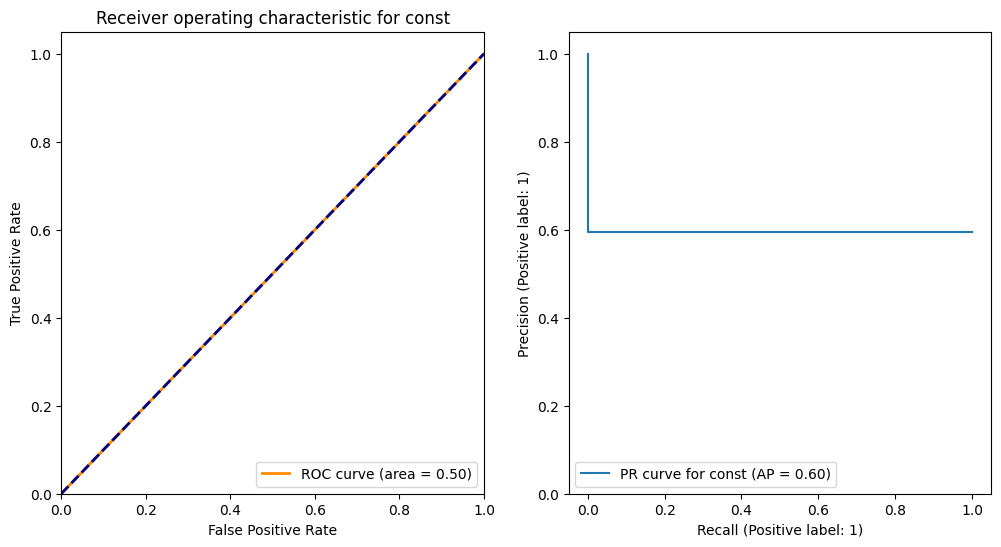

In [36]:
pred = const_model.predict(df_test)
evaluate('const', pred, pred, df_test['is_solved'])

In [37]:
df_train.head(3)

,assignment_level,attempts_date_created,cl_date_assignment,cl_id,cls_date_created,cls_student_id,course_id,is_solved,problem_id,subject_slug,team_id,team_level,tp_teacher_id,execution_time,att_id,prerec_info,solved_cur,attemp_cur,solved_rec,attemp_rec
2742039,4,2022-02-03 10:52:10+03:00,2022-02-03 08:00:00+03:00,63536805,2022-02-03 10:42:40+03:00,1503,5115187,1,2701,mathematics,62493,5,1286779,570.0,2742039,"{'solved_cur': 1, 'attemp_cur': 2, 'solved_rec...",0.500000,2,1.000000,1
2591948,4,2022-01-28 16:57:22+03:00,2022-01-28 11:03:07.674235+03:00,62112393,2022-01-28 16:55:47+03:00,4697,5096096,0,14818,mathematics,73493,4,508159,95.0,2591948,"{'solved_cur': 1, 'attemp_cur': 3, 'solved_rec...",0.333333,3,0.571429,7
3811793,4,2022-04-13 11:47:23+03:00,2022-04-12 23:44:30.611840+03:00,76392169,2022-04-13 11:10:31+03:00,11793,5102485,0,10489,mathematics,30947,5,727434,2212.0,3811793,"{'solved_cur': 2, 'attemp_cur': 2, 'solved_rec...",1.000000,2,0.500000,2


In [38]:
problem_info = df_train.groupby(by=['problem_id'])[['is_solved']].mean()
problem_info.columns = ['mean_problem_solved']

In [39]:
students_info = df_train.groupby(by=['cls_student_id'])[['is_solved']].mean()
students_info.columns = ['mean_student_solved']

In [40]:
problem_info['execution_time'] = df_train.groupby(by=['problem_id'])['execution_time'].median()
students_info['execution_time'] = df_train.groupby(by=['cls_student_id'])['execution_time'].median()

In [41]:
difficulty_math = pd.read_excel('ctt_simple.xlsx')
difficulty_math = difficulty_math[1:]
difficulty_math['problem_id'] = difficulty_math['problem_id'].apply(lambda x: problem_to_index[x] if x in problem_to_index else np.nan)
difficulty_math = difficulty_math.dropna()
difficulty_math['problem_id'] = difficulty_math['problem_id'].astype(int)
difficulty_math = difficulty_math.set_index(['problem_id'])
difficulty_math['difficulty'] = difficulty_math['difficulty'].astype(float)
difficulty_math = difficulty_math.groupby(by='problem_id')['difficulty'].mean()
difficulty_math.head()

problem_id
0    0.160210
1    0.199739
2    0.276843
3    0.118293
4    0.260465
Name: difficulty, dtype: float64

In [42]:
problem_info = problem_info.join(difficulty_math)
problem_info['has_diff_info'] = ((problem_info['difficulty'].isna()) | (problem_info['difficulty'] == 0)).astype(int)
problem_info['difficulty'] = problem_info['difficulty'].fillna(0)
problem_info.head(3)

,mean_problem_solved,execution_time,difficulty,has_diff_info
problem_id,,,,
0,0.777778,673.0,0.160210,0
1,0.764706,2385.5,0.199739,0
2,0.000000,5715213.0,0.276843,0


In [43]:
df_train.columns

Index(['assignment_level', 'attempts_date_created', 'cl_date_assignment',
       'cl_id', 'cls_date_created', 'cls_student_id', 'course_id', 'is_solved',
       'problem_id', 'subject_slug', 'team_id', 'team_level', 'tp_teacher_id',
       'execution_time', 'att_id', 'prerec_info', 'solved_cur', 'attemp_cur',
       'solved_rec', 'attemp_rec'],
      dtype='object')

In [44]:
lin_df_train = df_train[['problem_id', 'cls_student_id', 'is_solved', 'assignment_level',
                        'solved_cur', 'attemp_cur', 'solved_rec', 'attemp_rec']]
lin_df_test = df_test[['problem_id', 'cls_student_id', 'is_solved', 'assignment_level',
                        'solved_cur', 'attemp_cur', 'solved_rec', 'attemp_rec']]

lin_df_train = lin_df_train.join(problem_info, on='problem_id', rsuffix='_problem')
lin_df_train = lin_df_train.join(students_info, on='cls_student_id', rsuffix='_student')

lin_df_test = lin_df_test.join(problem_info, on='problem_id', rsuffix='_problem')
lin_df_test = lin_df_test.join(students_info, on='cls_student_id', rsuffix='_student')

# als_model = utils.get_als_model('als_model.pth')
# for param in als_model.parameters():
#     param.requires_grad = False
    
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
# train_st_emb = als_model.stud_embed(torch.IntTensor(lin_df_train.cls_student_id))
# train_pr_emb = als_model.problem_embed(torch.IntTensor(lin_df_train.problem_id))
# lin_df_train['cos_als_sim'] = cos(train_st_emb, train_pr_emb).numpy()

# test_st_emb = als_model.stud_embed(torch.IntTensor(lin_df_test.cls_student_id))
# test_pr_emb = als_model.problem_embed(torch.IntTensor(lin_df_test.problem_id))
# lin_df_test['cos_als_sim'] = cos(test_st_emb, test_pr_emb).numpy()

# lin_df_train['prod_als_sim'] = (train_st_emb * train_pr_emb).sum(dim=-1).numpy()
# lin_df_test['prod_als_sim'] = (test_st_emb * test_pr_emb).sum(dim=-1).numpy()

# lin_model = utils.get_lin_model('lin_model.pth')
# for param in lin_model.parameters():
#     param.requires_grad = False

# train_st_emb = lin_model.stud_embed(torch.IntTensor(lin_df_train.cls_student_id))
# train_pr_emb = lin_model.problem_embed(torch.IntTensor(lin_df_train.problem_id))
# lin_df_train['cos_lin_sim'] = cos(train_st_emb, train_pr_emb).numpy()

# test_st_emb = lin_model.stud_embed(torch.IntTensor(lin_df_test.cls_student_id))
# test_pr_emb = lin_model.problem_embed(torch.IntTensor(lin_df_test.problem_id))
# lin_df_test['cos_lin_sim'] = cos(test_st_emb, test_pr_emb).numpy()

# lin_df_train['prod_lin_sim'] = (train_st_emb * train_pr_emb).sum(dim=-1).numpy()
# lin_df_test['prod_lin_sim'] = (test_st_emb * test_pr_emb).sum(dim=-1).numpy()

lin_df_train.head(2)

,problem_id,cls_student_id,is_solved,assignment_level,solved_cur,attemp_cur,solved_rec,attemp_rec,mean_problem_solved,execution_time,difficulty,has_diff_info,mean_student_solved,execution_time_student
2742039,2701,1503,1,4,0.500000,2,1.000000,1,0.641841,478.0,0.292078,0,0.637931,380.5
2591948,14818,4697,0,4,0.333333,3,0.571429,7,0.669615,104.0,0.260953,0,0.313869,287.5


In [45]:
lin_X_train = lin_df_train[['mean_problem_solved', 'mean_student_solved']] 
lin_y_train = lin_df_train['is_solved']

lin_X_test = lin_df_test[['mean_problem_solved', 'mean_student_solved']] 
lin_y_test = lin_df_test['is_solved']

In [46]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

precision:0.707, recall:0.862, acc: 0.705


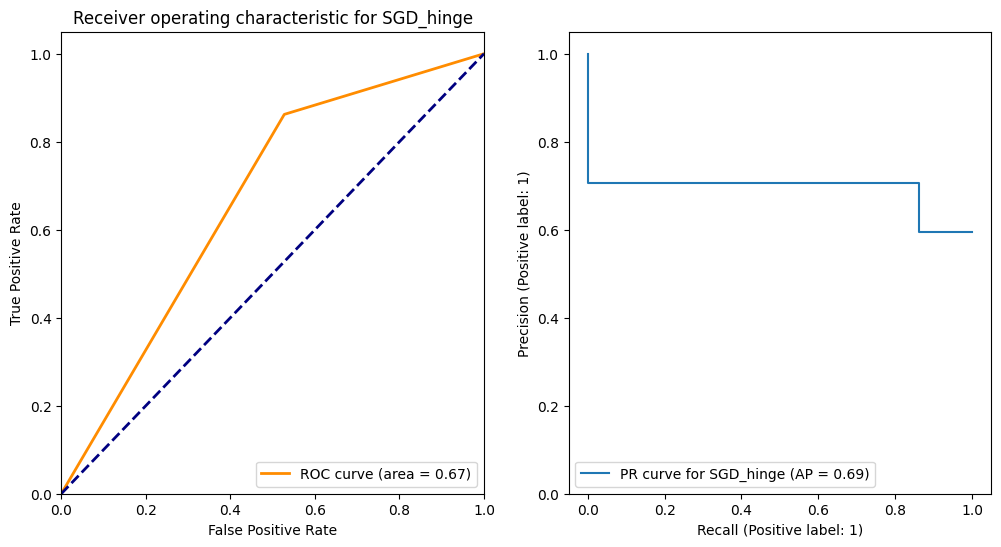

In [47]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(lin_X_train, lin_y_train)

pred = clf.predict(lin_X_test)
evaluate("SGD_hinge", pred, pred, lin_y_test)

precision:0.707, recall:0.861, acc: 0.705


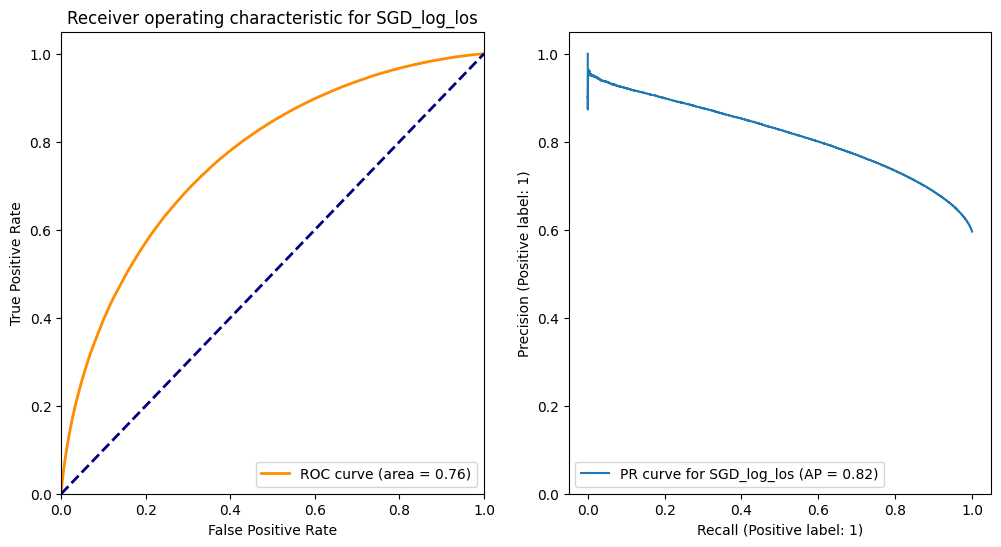

In [48]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss'))
clf.fit(lin_X_train, lin_y_train)

pred_proba = clf.predict_proba(lin_X_test)[:,1]
pred = clf.predict(lin_X_test)
evaluate("SGD_log_los", pred_proba, pred, lin_y_test)

precision:0.708, recall:0.857, acc: 0.704


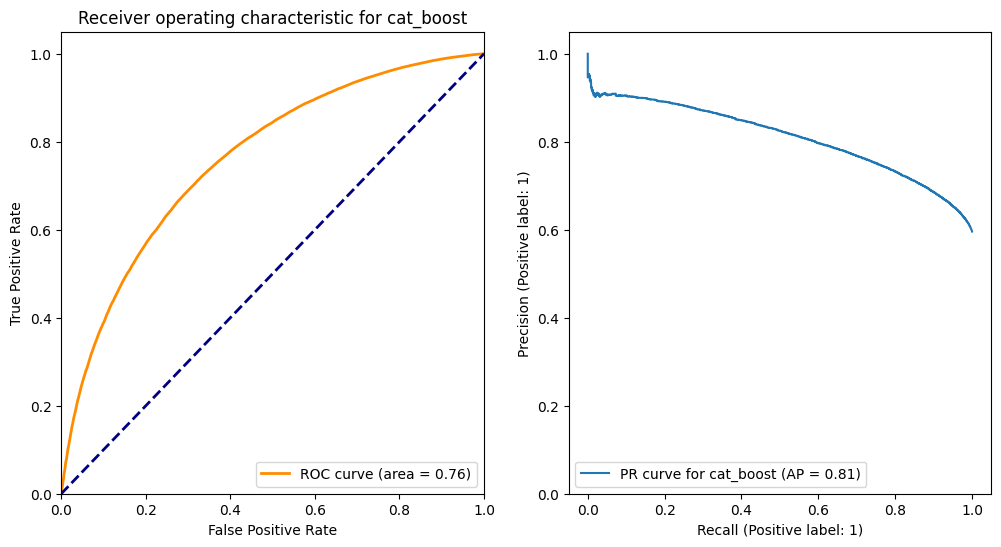

In [49]:
cat_class = CatBoostClassifier(iterations=50, depth=2,
                           task_type="GPU",
                           devices='0:1', logging_level='Silent')
cat_class.fit(lin_X_train, lin_y_train)
pred_proba = cat_class.predict_proba(lin_X_test)[:,1]
pred = cat_class.predict(lin_X_test)
evaluate("cat_boost", pred_proba, pred, lin_y_test)

In [50]:
train_cols = list(set(lin_df_train.columns).difference(['is_solved', 'problem_id', 'cls_student_id']))

lin_X_train = lin_df_train[train_cols] 
lin_y_train = lin_df_train['is_solved']

lin_X_test = lin_df_test[train_cols] 
lin_y_test = lin_df_test['is_solved']

lin_X_train.head(2)

,attemp_cur,solved_rec,execution_time,difficulty,execution_time_student,mean_student_solved,mean_problem_solved,has_diff_info,attemp_rec,assignment_level,solved_cur
2742039,2,1.000000,478.0,0.292078,380.5,0.637931,0.641841,0,1,4,0.500000
2591948,3,0.571429,104.0,0.260953,287.5,0.313869,0.669615,0,7,4,0.333333


precision:0.716, recall:0.855, acc: 0.711


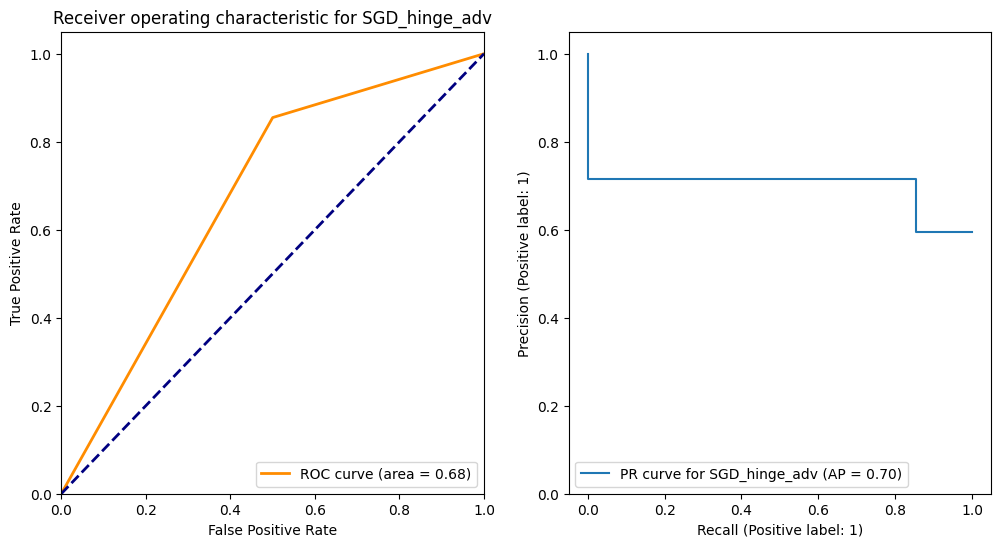

In [51]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(lin_X_train, lin_y_train)

pred = clf.predict(lin_X_test)
evaluate("SGD_hinge_adv", pred, pred, lin_y_test)

precision:0.718, recall:0.852, acc: 0.712


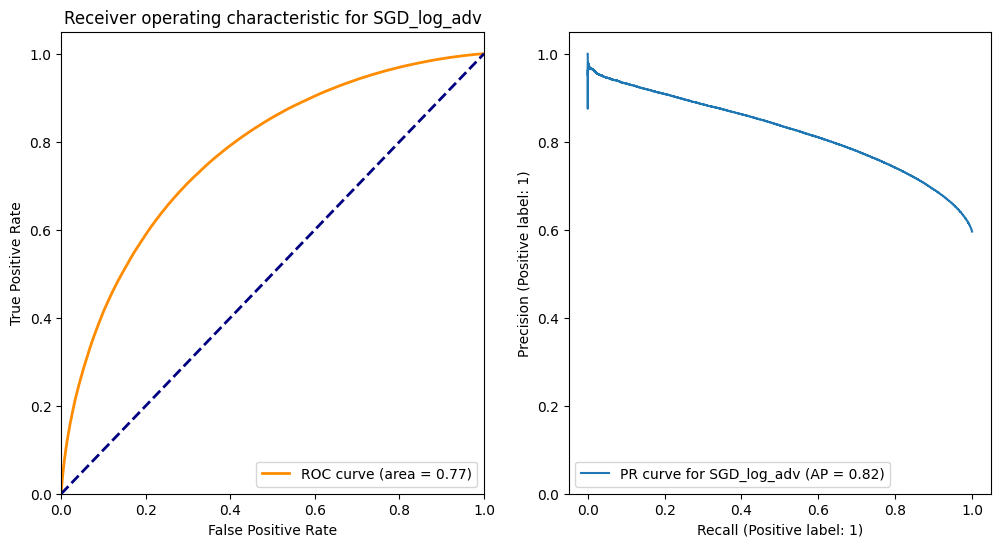

In [52]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss'))
clf.fit(lin_X_train, lin_y_train)

pred_proba = clf.predict_proba(lin_X_test)[:,1]
pred = clf.predict(lin_X_test)
evaluate("SGD_log_adv", pred_proba, pred, lin_y_test)

precision:0.73, recall:0.85, acc: 0.723


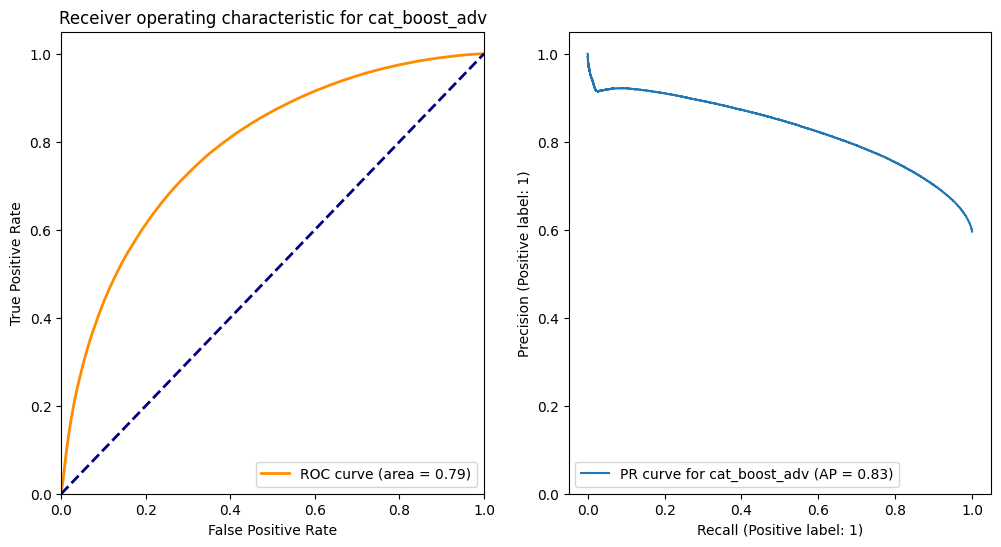

In [53]:
cat_class = CatBoostClassifier(iterations=1000, depth=10,
                           task_type="GPU",
                           devices='0:1', logging_level='Silent')
cat_class.fit(lin_X_train, lin_y_train)
pred_proba = cat_class.predict_proba(lin_X_test)[:,1]
pred = cat_class.predict(lin_X_test)
evaluate("cat_boost_adv", pred_proba, pred, lin_y_test)

In [54]:
lin_df_train.columns

Index(['problem_id', 'cls_student_id', 'is_solved', 'assignment_level',
       'solved_cur', 'attemp_cur', 'solved_rec', 'attemp_rec',
       'mean_problem_solved', 'execution_time', 'difficulty', 'has_diff_info',
       'mean_student_solved', 'execution_time_student'],
      dtype='object')

In [55]:
train_cols = list(set(lin_df_train.columns).difference(['is_solved', 'problem_id', 'cls_student_id', 'solved_rec', 'attemp_rec']))

lin_X_train = lin_df_train[train_cols] 
lin_y_train = lin_df_train['is_solved']

lin_X_test = lin_df_test[train_cols] 
lin_y_test = lin_df_test['is_solved']

lin_X_train.head(2)

,attemp_cur,execution_time,difficulty,execution_time_student,mean_student_solved,mean_problem_solved,has_diff_info,assignment_level,solved_cur
2742039,2,478.0,0.292078,380.5,0.637931,0.641841,0,4,0.500000
2591948,3,104.0,0.260953,287.5,0.313869,0.669615,0,4,0.333333


precision:0.73, recall:0.849, acc: 0.723


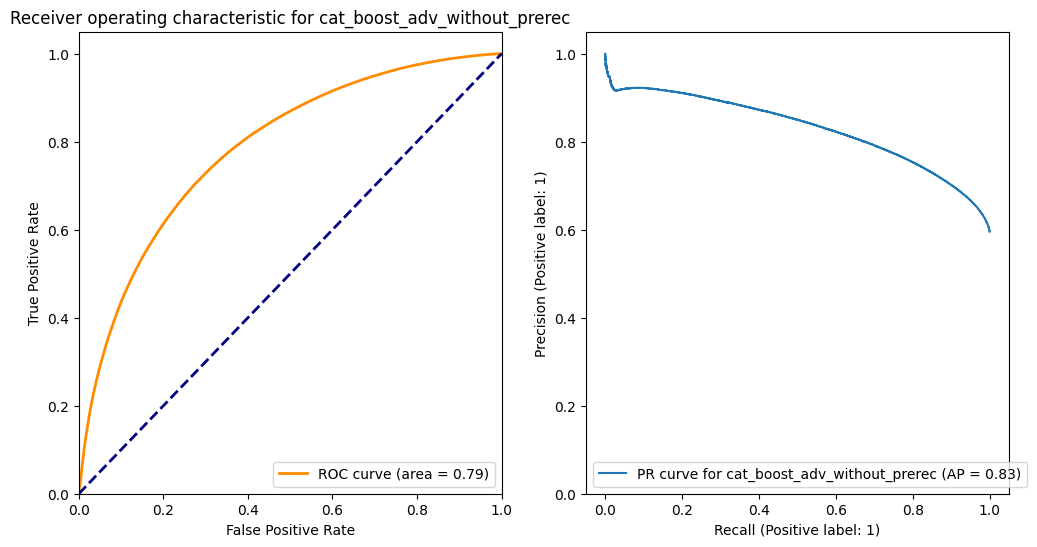

In [56]:
cat_class = CatBoostClassifier(iterations=1000, depth=10,
                           task_type="GPU",
                           devices='0:1', logging_level='Silent')
cat_class.fit(lin_X_train, lin_y_train)
pred_proba = cat_class.predict_proba(lin_X_test)[:,1]
pred = cat_class.predict(lin_X_test)
evaluate("cat_boost_adv_without_prerec", pred_proba, pred, lin_y_test)

In [57]:
train_cols = list(set(lin_df_train.columns).difference(['is_solved', 'problem_id', 'cls_student_id', 
                                                        'mean_problem_solved', 'mean_student_solved']))

lin_X_train = lin_df_train[train_cols] 
lin_y_train = lin_df_train['is_solved']

lin_X_test = lin_df_test[train_cols] 
lin_y_test = lin_df_test['is_solved']

lin_X_train.head(2)

,attemp_cur,solved_rec,execution_time,difficulty,execution_time_student,has_diff_info,attemp_rec,assignment_level,solved_cur
2742039,2,1.000000,478.0,0.292078,380.5,0,1,4,0.500000
2591948,3,0.571429,104.0,0.260953,287.5,0,7,4,0.333333


precision:0.742, recall:0.808, acc: 0.718


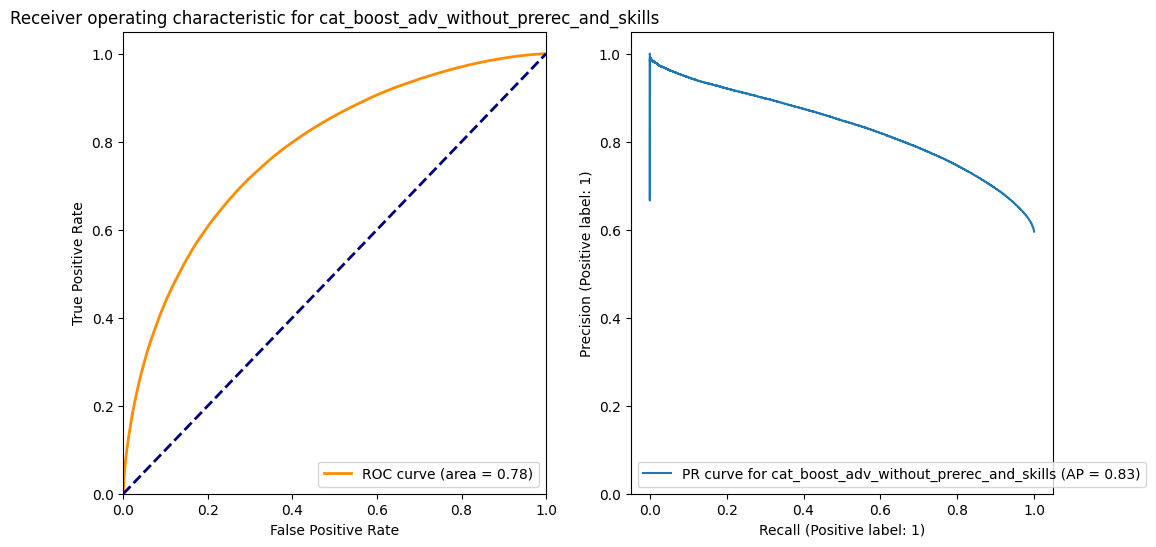

In [58]:
cat_class = CatBoostClassifier(iterations=1000, depth=10,
                           task_type="GPU",
                           devices='0:1', logging_level='Silent')
cat_class.fit(lin_X_train, lin_y_train)
pred_proba = cat_class.predict_proba(lin_X_test)[:,1]
pred = cat_class.predict(lin_X_test)
evaluate("cat_boost_adv_without_prerec_and_skills", pred_proba, pred, lin_y_test)

In [ ]:
r

In [59]:
acc

{'const': 0.595774882723254,
 'SGD_hinge': 0.7046031967770863,
 'SGD_log_los': 0.7047492012563595,
 'cat_boost': 0.7041669858637021,
 'SGD_hinge_adv': 0.7113978126365975,
 'SGD_log_adv': 0.7121801082415924,
 'cat_boost_adv': 0.7229979586410769,
 'cat_boost_adv_without_prerec': 0.7232115577866802,
 'cat_boost_adv_without_prerec_and_skills': 0.7182501092780439}

In [60]:
t_df = lin_X_test.iloc[:1000]

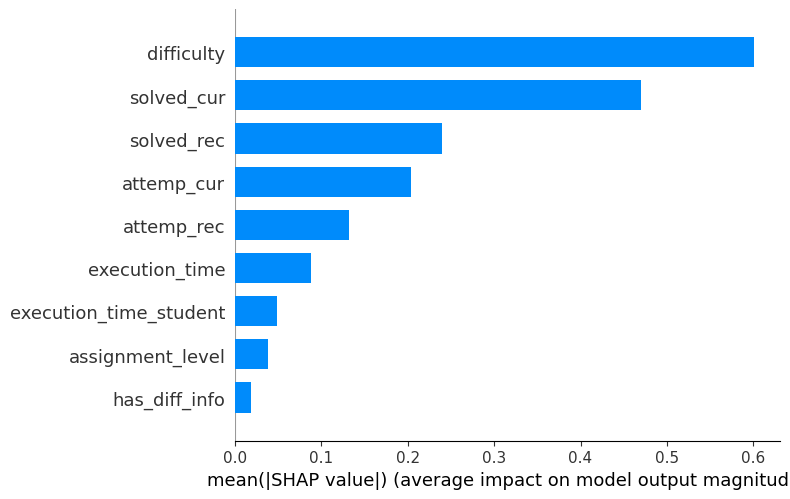

In [61]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cat_class)
shap_values = explainer.shap_values(t_df)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, t_df, plot_type="bar")

In [6]:
import json
from networkx.readwrite import json_graph

In [7]:
with open('graph_math') as f:
    graph_data = json.loads(f.read())

G = json_graph.node_link_graph(graph_data)

In [8]:
classes = set(" ".join(a.strip().split()) for a in G.nodes)

In [9]:
m = pd.read_excel('markup_math.xlsx', index_col=0)
m.head(3)

,attributes,limits,problem_id,skills,stack_id,units
1,NaN,В пределах 20,78236,решать задачи на нахождение числа элементов пе...,27125.0,NaN
2,NaN,В пределах 20,78236,сравнивать/упорядочивать числа меньшие или рав...,27125.0,NaN
3,NaN,В пределах 20,78236,решать задачи на упорядочивание множеств /величин,27125.0,NaN


In [10]:
skills = set(m['skills'])

In [11]:
len(classes), len(skills), len(skills.difference(classes))

(2001, 1098, 0)

In [12]:
len(classes)

2001

Так как задач у меня меньше, чем нод в графе, то попытаемся обрезать все ноды, которых нет у меня в задачах

In [13]:
diff = classes.difference(skills)
len(diff)

903

In [14]:
for v in diff:
    for in_v, _ in G.in_edges(v):
        for _, out_v in G.out_edges(v):
            if in_v == v:
                print('aaaaaaa')
            if out_v == v:
                print('aaaaaaa')
            if not G.has_edge(in_v, out_v):
                G.add_edge(in_v, out_v)
    G.remove_node(v)

In [15]:
len(skills)

1098

In [16]:
len(G.nodes),len(skills)

(1098, 1098)

In [17]:
df = df.sort_values(by=['attempts_date_created']).reset_index(drop=True)

Буду добавлять фичи:
сколько решил на текущую тему
сколько правильно

Сколько решил  на прошлые темы
сколько правильно

In [18]:
problems_has_themes = set(m['problem_id'])

In [19]:
df = pd.DataFrame(df[df['problem_id'].apply(lambda x: x in problems_has_themes)].reset_index(drop=True))

In [20]:
df['att_id'] = df.reset_index()['index']

In [21]:
from collections import defaultdict

problem_to_skill = defaultdict(list)
m.apply(lambda x: problem_to_skill[x['problem_id']].append(x['skills']), axis=1)
problem_to_skill = dict(problem_to_skill)

In [22]:
from dataclasses import dataclass, field

@dataclass
class StudInfo:
    skill_attemps: defaultdict[str, set] = field(default_factory=lambda:defaultdict(set))
    skill_solved: defaultdict[str, set] = field(default_factory=lambda:defaultdict(set))

In [23]:
stud_info = defaultdict(StudInfo)

In [24]:
_, a = next(iter(df.groupby(by=['cls_student_id'])))

/tmp/ipykernel_980543/1527633814.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  _, a = next(iter(df.groupby(by=['cls_student_id'])))


In [25]:
def compute_stud_info(row):     
    problem_id = row['problem_id']
    stud_id = row['cls_student_id']
    unic_id = row['att_id']
    
    solved_cur = set()
    attemp_cur = set()
    solved_rec = set()
    attemp_rec = set()
    
    for skill in problem_to_skill[problem_id]:
        attemp_cur = attemp_cur.union(stud_info[stud_id].skill_attemps[skill])
        solved_cur = solved_cur.union(stud_info[stud_id].skill_solved[skill])
        
        for _, prerec_skill in G.out_edges(skill):
            solved_rec = solved_rec.union(stud_info[stud_id].skill_solved[prerec_skill])
            attemp_rec = attemp_rec.union(stud_info[stud_id].skill_attemps[prerec_skill])
            
            for _, prepre_skill in G.out_edges(prerec_skill):
                solved_rec = solved_rec.union(stud_info[stud_id].skill_solved[prepre_skill])
                attemp_rec = attemp_rec.union(stud_info[stud_id].skill_attemps[prepre_skill])
        
        stud_info[stud_id].skill_attemps[skill].add(unic_id)
        if row['is_solved']:
            stud_info[stud_id].skill_solved[skill].add(unic_id)
            
    solved_cur.discard(unic_id)
    attemp_cur.discard(unic_id)
    solved_rec.discard(unic_id)
    attemp_rec.discard(unic_id)
    
    res = {
        'solved_cur': len(solved_cur),
        'attemp_cur': len(attemp_cur),
        'solved_rec': len(solved_rec),
        'attemp_rec': len(attemp_rec),
    }
    return res
    
    

In [26]:
%%time
df['prerec_info'] = df.apply(compute_stud_info, axis=1)

CPU times: user 6min 2s, sys: 4.17 s, total: 6min 6s
Wall time: 6min 6s


In [27]:
df['solved_cur'] =  df['prerec_info'].apply(lambda x: x['solved_cur'] / x['attemp_cur'] if x['attemp_cur'] else 0)
df['attemp_cur'] =  df['prerec_info'].apply(lambda x: x['attemp_cur'])
df['solved_rec'] =  df['prerec_info'].apply(lambda x: x['solved_rec'] / x['attemp_rec'] if x['attemp_rec'] else 0)
df['attemp_rec'] =  df['prerec_info'].apply(lambda x: x['attemp_rec'])